In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

# Рекомендации в онлайн магазине

**Гипотеза:**
1. изменили блок рекомендаций на рекомендации красивых чехлов
2. ожидаем, что это приведет к увеличению продаж аксессуаров
3. сможем увидеть это по метрике - средняя выручка от продажи аксессуаров

В качестве метрики взяли продажи всех аксессуаров, а не только чехлов, тк реклама именно чехлов может каннибализировать
продажу других видов аксессуаров.

**Пилот:**
* случайно разбиваем пользователей, зашедших на сайт, в контрольную или пилотную группы
* в контрольной группе показываем старые рекомендации, а в пилотной - новые
* ждем 14 дней
* за это время в группах оказалось по 110523 пользовательских сессии

In [3]:
  URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'

In [4]:
def read_database(file_name):
    return pd.read_csv(URL_BASE + file_name, index_col=0)

In [5]:
data = read_database('sem2_task1.csv')

In [6]:
print(f'data shape : {data.shape}')
data.sample(10)

data shape : (6452, 5)


,day,cost_phones,cost_cases,cost_accessories,group
2039,9,43500,1800,2600,control
3089,14,40700,2900,0,control
6318,14,39300,0,0,pilot
5428,10,32500,0,0,pilot
4432,6,49600,2300,0,pilot
6106,13,26000,0,2700,pilot
438,2,55100,1900,3100,control
1588,7,62700,0,0,control
1641,8,6900,1200,3000,control
3018,14,47800,0,2500,control


Для начала мы можем посмотреть на простую, но вместе с тем красивую картунку. В пилотной группе трафик больше, чем в
контрольной.

/var/folders/wt/fs62y8p10lxgyr__1q15y4_m0000gn/T/ipykernel_2866/3487770176.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='group', data=data, legend=False, palette='hls')


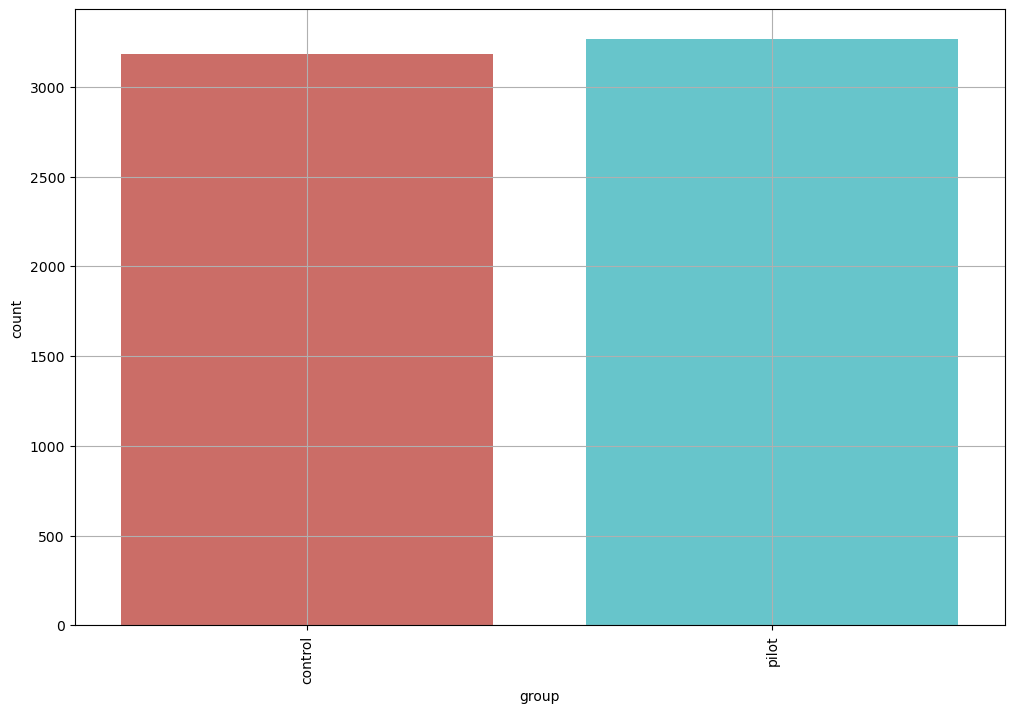

In [7]:
sns.countplot(x='group', data=data, legend=False, palette='hls')
plt.xticks(rotation=90)
plt.grid()

# Дашбоард эксперемента

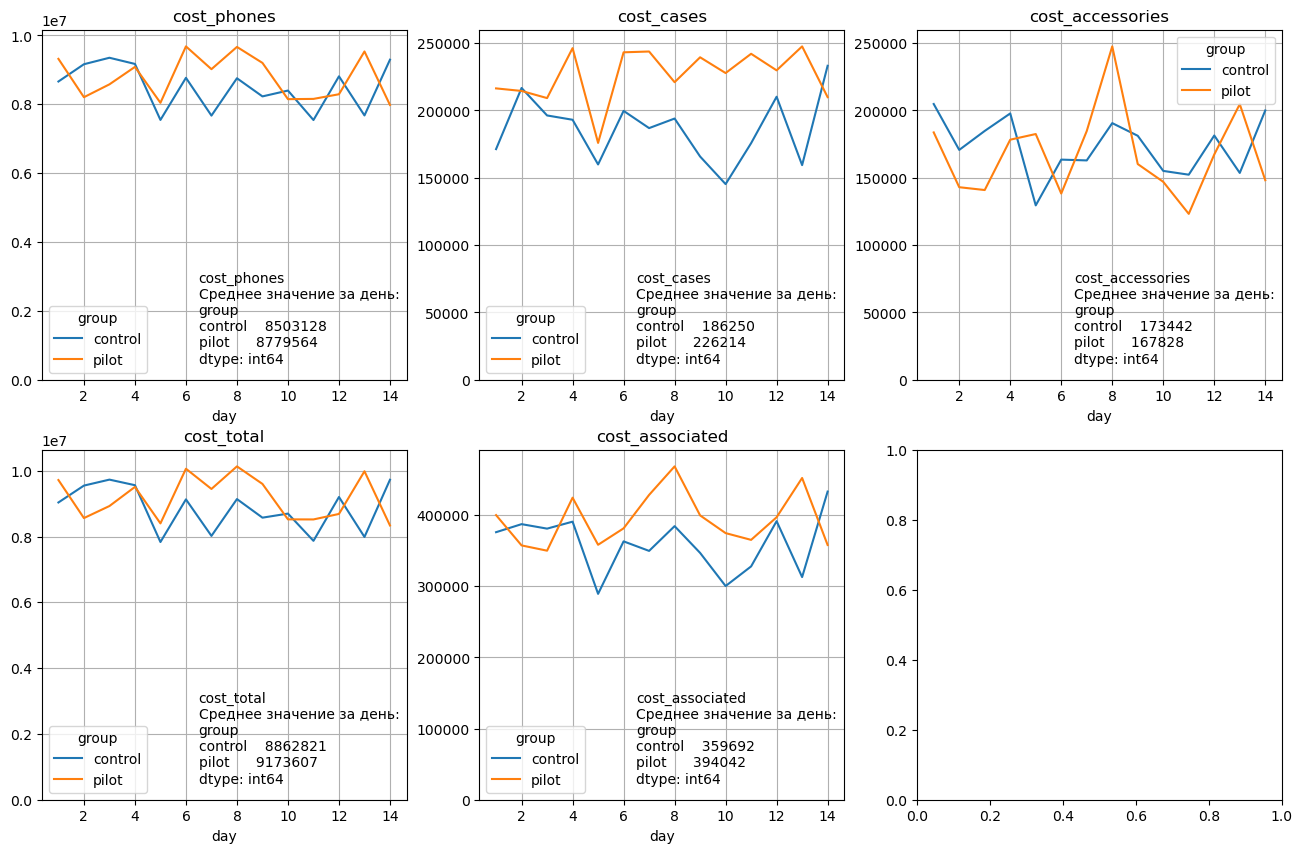

In [10]:
data_sint = data.copy()
data_sint['cost_total'] = data[['cost_phones', 'cost_cases', 'cost_accessories']].sum(axis=1)
data_sint['cost_associated'] = data[['cost_cases', 'cost_accessories']].sum(axis=1)
cost_columns = [c for c in data_sint.columns if 'cost' in c]

fig, ax = plt.subplots(2, 3, figsize=(16, 10))

for column, ax in zip(cost_columns, ax.flatten()): 
    data_groupby = data_sint.groupby(['day', 'group'])[[column]].sum().reset_index()
    data_pivot = data_groupby.pivot(index='day', columns='group', values=column)
    data_pivot.plot(ax=ax, grid=True)
    ax.set_title(column)
    y_max = data_groupby[column].max()
    ax.set_ylim([0, y_max * 1.05])
    annotation = f'{column}\nСреднее значение за день:\n{data_pivot.mean().astype(int)}'
    ax.text(6.5, .05 * y_max, annotation)

# Визуальное сравнение распределений
Давайте немного подробновлсей посмотрим на статистики. Для этого построим гистограммы по всем метрикам.

In [11]:
print(data['group'].value_counts(), '\n')

for column in data.drop('group', axis=1).columns:
    print(column)
    for group in ['control', 'pilot']:
        data_ = data[data['group'] == group][column]
        print(' ', round(data_.mean(), 2), data_.nunique(), data_.min(), data_.max())

pilot      3267
control    3185
Name: group, dtype: int64 

day
  7.41 14 1 14
  7.46 14 1 14
cost_phones
  37376.39 724 4100 100800
  37622.87 735 4100 104100
cost_cases
  818.68 36 0 4200
  969.39 38 0 4000
cost_accessories
  762.39 55 0 6500
  719.19 57 0 6300


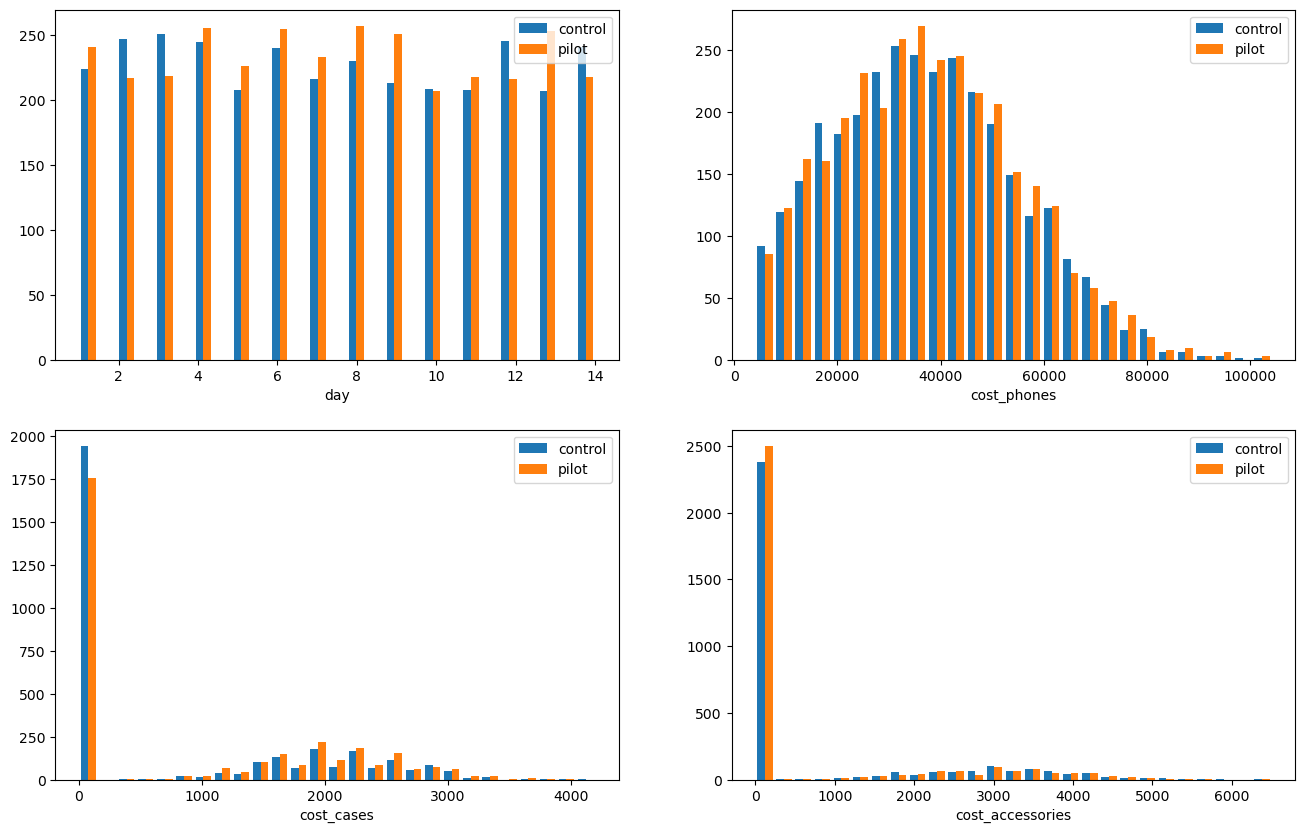

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
for column, ax in zip(data.drop('group', axis=1).columns, 
                     ax.flatten()):
    ax.set_xlabel(column)
    data_pilot = data[data['group'] == 'pilot'][column].values
    data_control = data[data['group'] == 'control'][column].values
    bins = np.linspace(data[column].min(), data[column].max(), 28)
    ax.hist([data_control, data_pilot], bins, label=['control', 'pilot'])
    ax.legend()

# Вычисление метрик
Для группировки данных нам понадобится функция pandas.DataFrame.groupby,
а для сбора аггрегированной статистики можно воспользоваться pandas.DataFrame.aggregate

In [15]:
data_grouped = data.groupby('group').agg(
    traffic = ('group', 'count'),
    revenue_phones = ('cost_phones', 'sum'),
    revenue_cases = ('cost_cases', 'sum'),
    revenue_accesssories = ('cost_accessories', 'sum')
)
data_grouped

,traffic,revenue_phones,revenue_cases,revenue_accesssories
group,,,,
control,3185,119043800,2607500,2428200
pilot,3267,122913900,3167000,2349600


<Axes: >

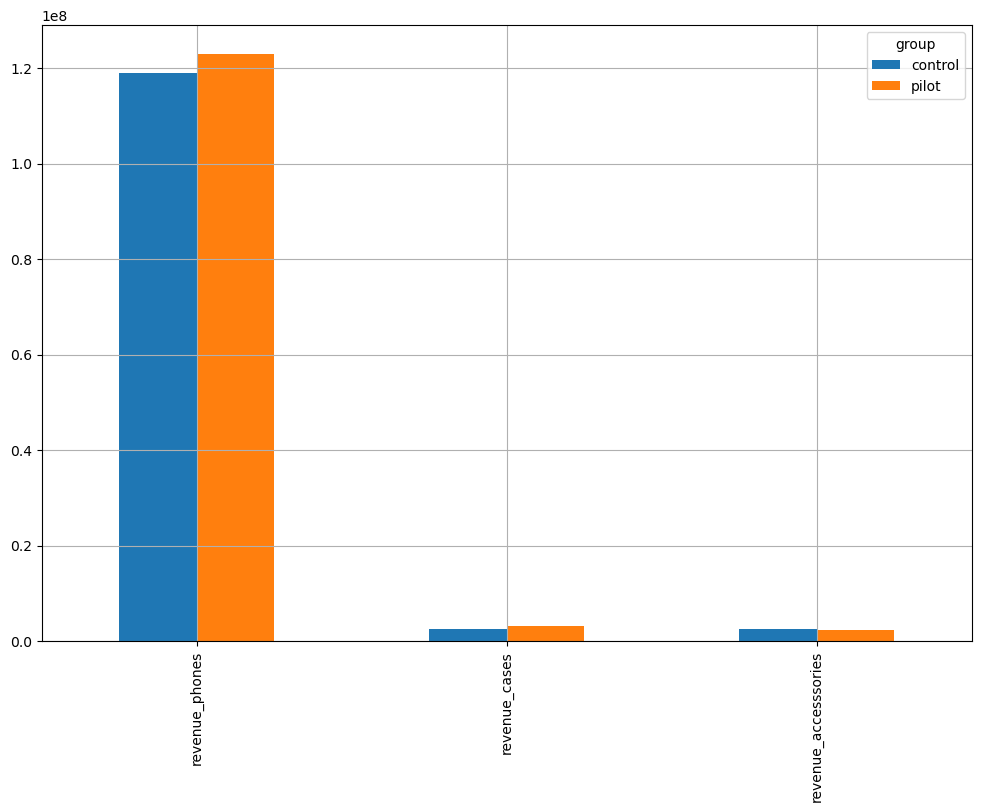

In [16]:
revenue = data_grouped[[col for col in data_grouped.columns if 'revenue' in col]].T
revenue.plot(kind='bar', grid=True)

<Axes: >

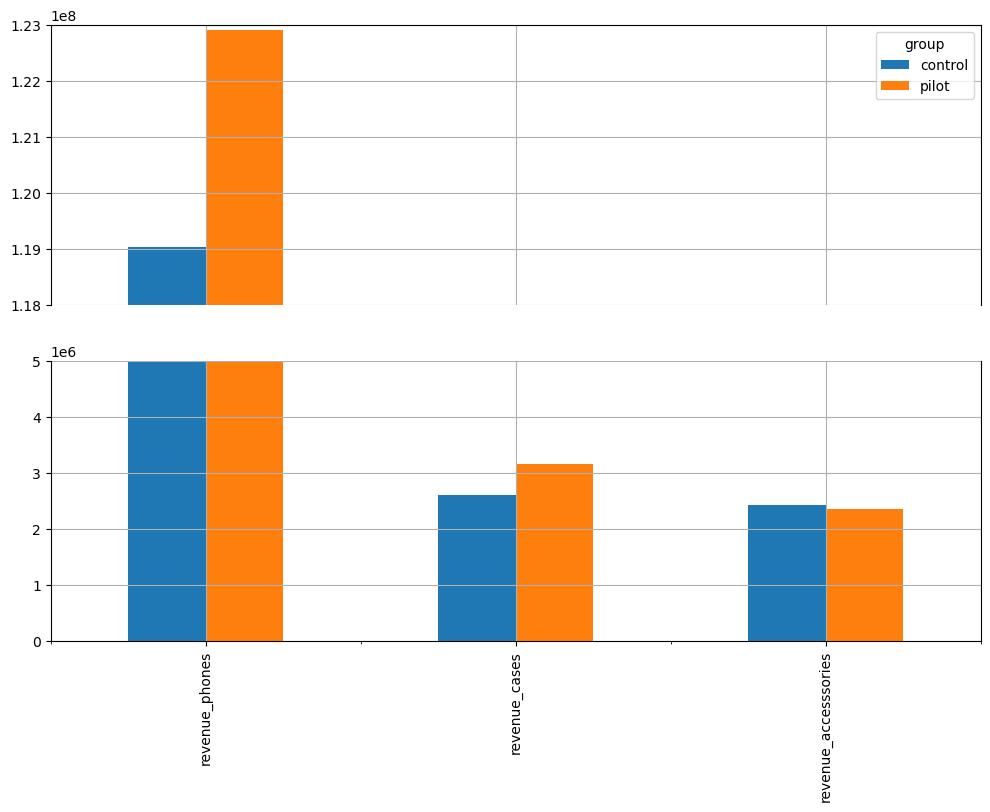

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x', which='both', bottom=False)
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0, 5 * 10 ** 6)
ax1.set_ylim(118 * 10 ** 6, 123 * 10 ** 6)

revenue.plot(ax=ax1, kind='bar', grid=True)
revenue.plot(ax=ax2, kind='bar', legend=False, grid=True)

In [18]:
data_sint.groupby('group')[cost_columns].mean().astype(int)

,cost_phones,cost_cases,cost_accessories,cost_total,cost_associated
group,,,,,
control,37376,818,762,38957,1581
pilot,37622,969,719,39311,1688


# Проверка статистической значимости

In [20]:
GROUP_SIZE = 110_523

for column in cost_columns:
    print(column)
    a_values_nonzero = data_sint[data_sint['group'] == 'control'][column].values
    b_values_nonzero = data_sint[data_sint['group'] == 'pilot'][column].values

    a_values = np.zeros(GROUP_SIZE)
    b_values = np.zeros(GROUP_SIZE)
    a_values[:len(a_values_nonzero)] = a_values_nonzero
    b_values[:len(b_values_nonzero)] = b_values_nonzero

    delta = b_values.mean() - a_values.mean()
    _, pvalue = stats.ttest_ind(a_values, b_values)
    print(f'  delta = {round(delta, 2)}')
    print(f'  pvalue = {round(pvalue, 3)}', '- значимо' if pvalue < .05 else '') 

cost_phones
  delta = 35.02
  pvalue = 0.24 
cost_cases
  delta = 5.06
  pvalue = 0.0 - значимо
cost_accessories
  delta = -0.71
  pvalue = 0.533 
cost_total
  delta = 39.37
  pvalue = 0.202 
cost_associated
  delta = 4.35
  pvalue = 0.013 - значимо


Получили, что целевая метрика статистически значимо увеличилась. Большинство контрольных метрик
согласуются с гипотезой.